In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [3]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [ ]:
edges = network.get_edgelist(edge_types=["d"], node_list=network.nodes["GE"], databases=["BioGRID"])
network.G.remove_edges_from(edges)

In [4]:
import pickle
with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network_val.multi_omics_data = luad_data
    network.process_genes_info()
    network_val.process_genes_info()

Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -44
Total nodes (filtered): 32697
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -21066
Total nodes (filtered): 11675


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

KeyboardInterrupt: 

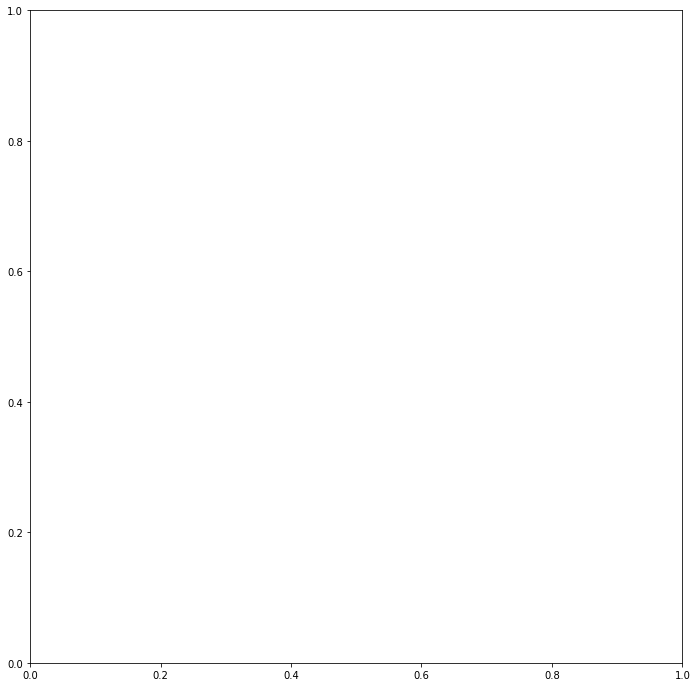

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

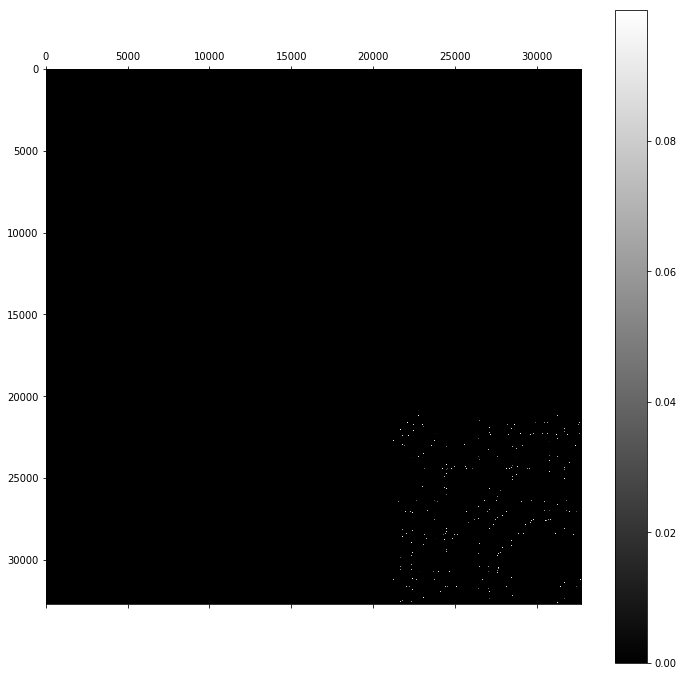

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

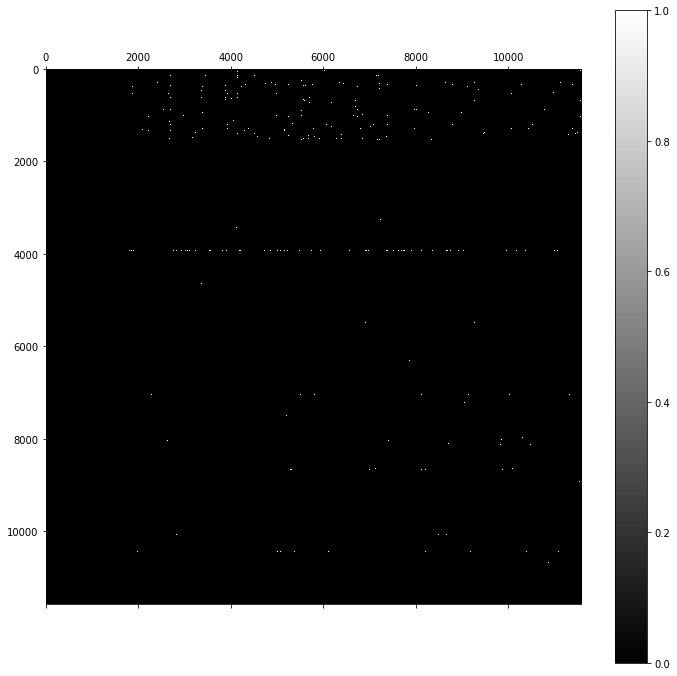

In [5]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [ ]:
params = {
    'd': 128, 
    'lr': 0.001, 
    'margin': 0.5,
    'compression_func': 'sqrt',
    'negative_sampling_ratio': 10.0,
    'max_length': 8000, 
    'truncating': 'random', 
    
    'conv1_kernel_size': 18, 
    'conv1_batch_norm': True,
    'max1_pool_size': 9, 
    'conv2_kernel_size': 4,
    'conv2_batch_norm': True,
    'max2_pool_size': 2, 
    'lstm_unit_size': 160, 
    'dense1_unit_size': 1024, 
    'dense2_unit_size': None, 
    'directed_distance': "dot_sigmoid",
    'undirected_distance': "dot_sigmoid",
    'source_target_dense_layers': True,
    'embedding_normalization': False
}

In [ ]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
from moge.embedding.siamese_triplet_online_embedding import SiameseOnlineTripletGraphEmbedding

siamese = SiameseOnlineTripletGraphEmbedding(batch_size=225, epochs=50, verbose=True)
# siamese = SiameseGraphEmbedding(d=128, batch_size=1024, lr=0.001, epochs=50, negative_sampling_ratio=2.0,
#                                  max_length=2000, truncating="post", verbose=True)

# siamese = SiameseTripletGraphEmbedding(d=128, batch_size=256, margin=0.2, lr=0.001, epochs=30, 
#     negative_sampling_ratio=2.0, directed_proba=0.8, compression_func="sqrt3",
#     max_length=2000, truncating="post", verbose=True)

siamese.set_params(**params)

Using TensorFlow backend.


SiameseOnlineTripletGraphEmbedding(batch_size=225, compression_func='sqrt',
                  conv1_batch_norm=True, conv1_kernel_size=18,
                  conv2_batch_norm=True, conv2_kernel_size=4, d=128,
                  dense1_unit_size=1024, dense2_unit_size=None,
                  directed_distance='dot_sigmoid', directed_proba=0.5,
                  embedding_normalization=False, epochs=50, lr=0.001,
                  lstm_unit_size=160, margin=0.5, max1_pool_size=9,
                  max2_pool_size=2, max_length=8000,
                  negative_sampling_ratio=10.0, seed=0,
                  source_target_dense_layers=True, truncating='random',
                  undirected_distance='dot_sigmoid', verbose=True)

In [ ]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=False, 
    n_steps=250, 
    tensorboard=True,
    seed=0)

Using SampledDataGenerator
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
# of nodes to sample from (non-zero degree): 28597
Using SampledDataGenerator
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
# of nodes to sample from (non-zero degree): 3782
labels_directed SparseTensor(indices=Tensor("labels_directed/indices:0", shape=(?, 2), dtype=int64, device=/device:GPU:0), values=Tensor("labels_directed/values:0", shape=(?,), dtype=float32, device=/device:GPU:0), dense_shape=Tensor("labels_directed/shape:0", shape=(2,), dtype=int64, device=/device:GPU:0))
labels_undirected SparseTensor(indices=Tensor("labels_undirected/indices:0", shape=(?, 2), dtype=int64, device=/device:GPU:0), values=Tensor("labels_undirected/values:0", shape=(?,), dtype=float32, device=/device:GPU:0), dense_shape=Tensor("labels_undirected/shape:0", shape=(2,), dtype=int64, device=/device:GPU:0))
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:GPU:0)
conv2D Tensor("

# Visualize Embeddings

In [ ]:
matrix_heatmap(siamese.get_embedding(recompute=True), cmap="bwr", aspect='auto', figsize=(7,10))

In [ ]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(), 
                                             interpolate=False), figsize=(7,7))

In [ ]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(), 
                                             interpolate=False), figsize=(7,7))

# Save Model & Embedding

In [21]:
siamese.lstm_network.save("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lstm_online_triplet_128.post.shortest.biogrid.full.euclidean.concatenated.e50.model.h5")
# siamese.alpha_network.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/alpha_128.randtrunc.multi_seq.no_starbase.sampled.l1_bce.e20.weights.h5")

In [14]:
siamese.siamese_net.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/siamese_online_triplet_128.post.shortest.biogrid.full.euclidean.e50.weights.h5")

In [11]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.triplet.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                        variable_length=False, recompute=False, minlen=100)

# Import different models

In [60]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
from moge.embedding.sequence_based_embedding import BioVecEmbedding, iDeepVEmbedding, LncTarInteraction

biovec_emb = BioVecEmbedding(network, {"MIR": "moge/data/biovec/miRNA_protvec.model",
                         "GE": "moge/data/biovec/mRNA_protvec.model",
                         "LNC": "moge/data/biovec/lncRNA_protvec.model"})

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)


print()

Failed to get vectors for hsa-let-7a-1
Failed to get vectors for hsa-let-7a-2
Failed to get vectors for hsa-let-7a-3
Failed to get vectors for hsa-let-7b
Failed to get vectors for hsa-let-7c
Failed to get vectors for hsa-let-7d
Failed to get vectors for hsa-let-7e
Failed to get vectors for hsa-let-7f-1
Failed to get vectors for hsa-let-7f-2
Failed to get vectors for hsa-let-7g
Failed to get vectors for hsa-let-7i
Failed to get vectors for hsa-mir-1-1
Failed to get vectors for hsa-mir-1-2
Failed to get vectors for hsa-mir-100
Failed to get vectors for hsa-mir-101-1
Failed to get vectors for hsa-mir-101-2
Failed to get vectors for hsa-mir-103a-1
Failed to get vectors for hsa-mir-103a-2
Failed to get vectors for hsa-mir-103b-1
Failed to get vectors for hsa-mir-103b-2
Failed to get vectors for hsa-mir-105-1
Failed to get vectors for hsa-mir-105-2
Failed to get vectors for hsa-mir-106a
Failed to get vectors for hsa-mir-106b
Failed to get vectors for hsa-mir-107
Failed to get vectors for hsa

Failed to get vectors for hsa-mir-3919
Failed to get vectors for hsa-mir-3920
Failed to get vectors for hsa-mir-3921
Failed to get vectors for hsa-mir-3922
Failed to get vectors for hsa-mir-3923
Failed to get vectors for hsa-mir-3924
Failed to get vectors for hsa-mir-3925
Failed to get vectors for hsa-mir-3926-1
Failed to get vectors for hsa-mir-3926-2
Failed to get vectors for hsa-mir-3927
Failed to get vectors for hsa-mir-3928
Failed to get vectors for hsa-mir-3929
Failed to get vectors for hsa-mir-3934
Failed to get vectors for hsa-mir-3935
Failed to get vectors for hsa-mir-3936
Failed to get vectors for hsa-mir-3937
Failed to get vectors for hsa-mir-3938
Failed to get vectors for hsa-mir-3939
Failed to get vectors for hsa-mir-3940
Failed to get vectors for hsa-mir-3941
Failed to get vectors for hsa-mir-3942
Failed to get vectors for hsa-mir-3943
Failed to get vectors for hsa-mir-3944
Failed to get vectors for hsa-mir-3945
Failed to get vectors for hsa-mir-3960
Failed to get vectors

Failed to get vectors for hsa-mir-515-1
Failed to get vectors for hsa-mir-515-2
Failed to get vectors for hsa-mir-516a-1
Failed to get vectors for hsa-mir-516a-2
Failed to get vectors for hsa-mir-516b-1
Failed to get vectors for hsa-mir-516b-2
Failed to get vectors for hsa-mir-517a
Failed to get vectors for hsa-mir-517b
Failed to get vectors for hsa-mir-517c
Failed to get vectors for hsa-mir-5186
Failed to get vectors for hsa-mir-5187
Failed to get vectors for hsa-mir-5188
Failed to get vectors for hsa-mir-5189
Failed to get vectors for hsa-mir-518a-1
Failed to get vectors for hsa-mir-518a-2
Failed to get vectors for hsa-mir-518b
Failed to get vectors for hsa-mir-518c
Failed to get vectors for hsa-mir-518d
Failed to get vectors for hsa-mir-518e
Failed to get vectors for hsa-mir-518f
Failed to get vectors for hsa-mir-5190
Failed to get vectors for hsa-mir-5191
Failed to get vectors for hsa-mir-5192
Failed to get vectors for hsa-mir-5193
Failed to get vectors for hsa-mir-5194
Failed to g

Failed to get vectors for hsa-mir-6855
Failed to get vectors for hsa-mir-6856
Failed to get vectors for hsa-mir-6857
Failed to get vectors for hsa-mir-6858
Failed to get vectors for hsa-mir-6859-1
Failed to get vectors for hsa-mir-6859-2
Failed to get vectors for hsa-mir-6859-3
Failed to get vectors for hsa-mir-6860
Failed to get vectors for hsa-mir-6861
Failed to get vectors for hsa-mir-6862-1
Failed to get vectors for hsa-mir-6862-2
Failed to get vectors for hsa-mir-6863
Failed to get vectors for hsa-mir-6864
Failed to get vectors for hsa-mir-6865
Failed to get vectors for hsa-mir-6866
Failed to get vectors for hsa-mir-6867
Failed to get vectors for hsa-mir-6868
Failed to get vectors for hsa-mir-6869
Failed to get vectors for hsa-mir-6870
Failed to get vectors for hsa-mir-6871
Failed to get vectors for hsa-mir-6872
Failed to get vectors for hsa-mir-6873
Failed to get vectors for hsa-mir-6874
Failed to get vectors for hsa-mir-6875
Failed to get vectors for hsa-mir-6876
Failed to get v

/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/static_graph_embedding.py:241: RuntimeWarning: overflow encountered in exp
  exps = np.exp(X)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/static_graph_embedding.py:242: RuntimeWarning: invalid value encountered in true_divide
  return exps/np.sum(exps, axis=0)


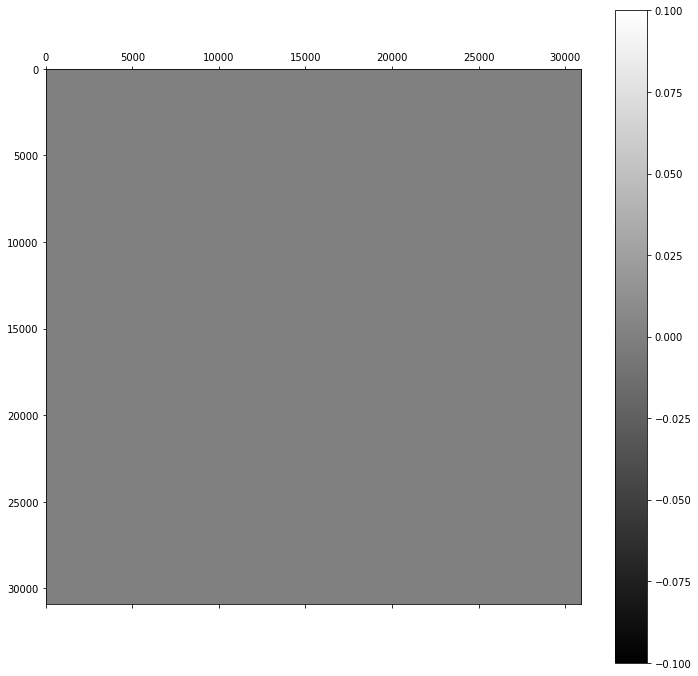

In [61]:
matrix_heatmap(biovec_emb.get_reconstructed_adj())

In [59]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
methods["rna2rna"] = rna2rna_emb
methods["siamese"] = siamese

# Prepare True label

In [27]:
from moge.network.edge_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=1,
                             maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_Ed.on_epoch_end()


Ed_count: 88283 , Eu_count: 0 , En_count: 0
Ens_count: 176566
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}


# Plot Precision-Recall Curve

lncrna2target
Ed_count: 564 , Eu_count: 0 , En_count: 0


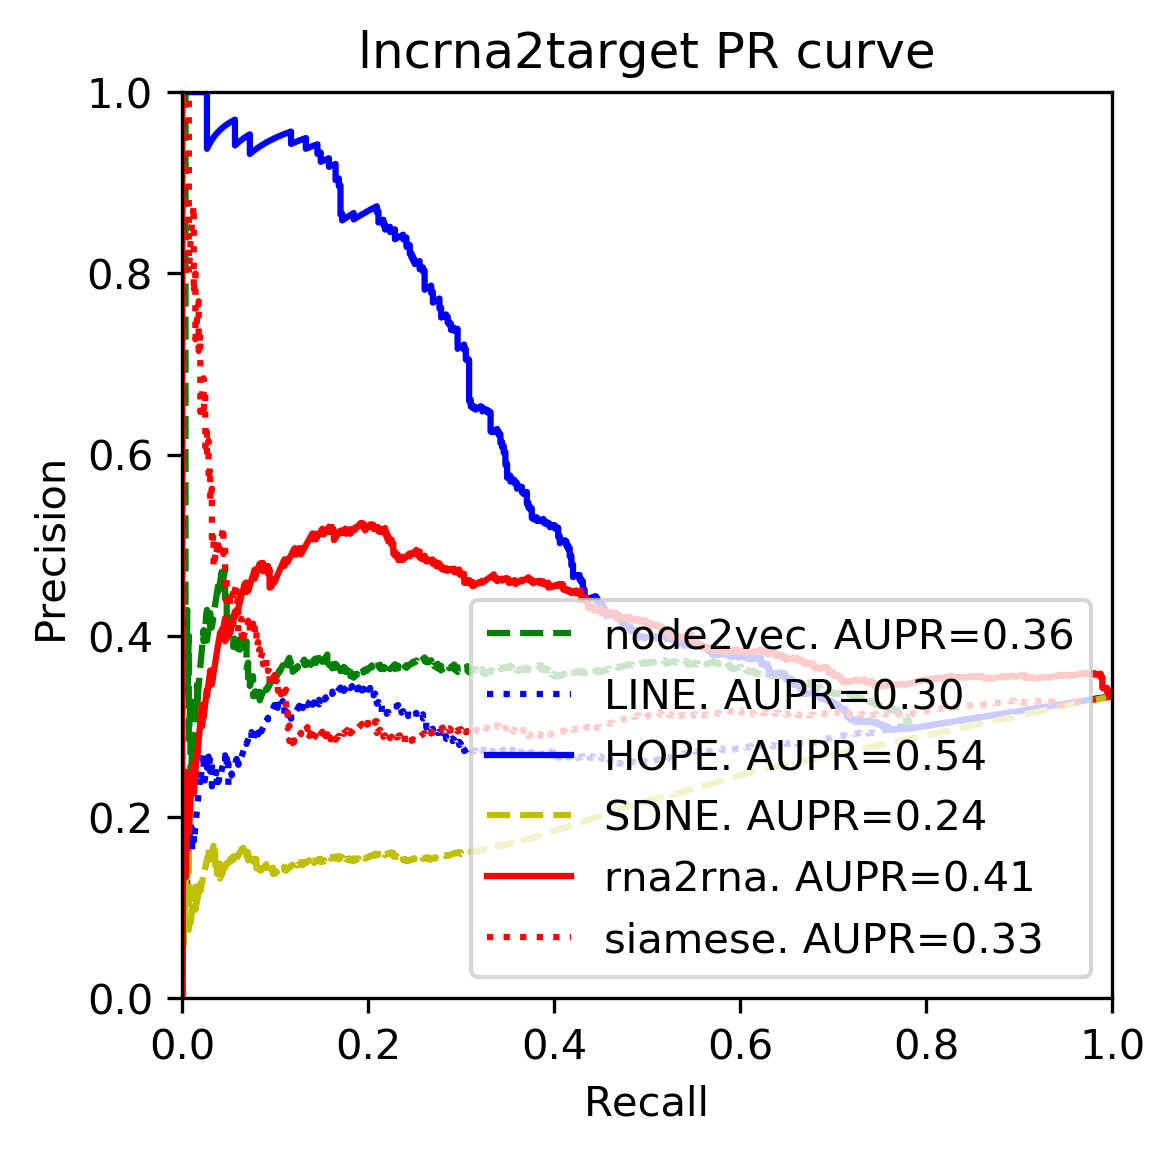

miRTarBase
Ed_count: 55895 , Eu_count: 0 , En_count: 0


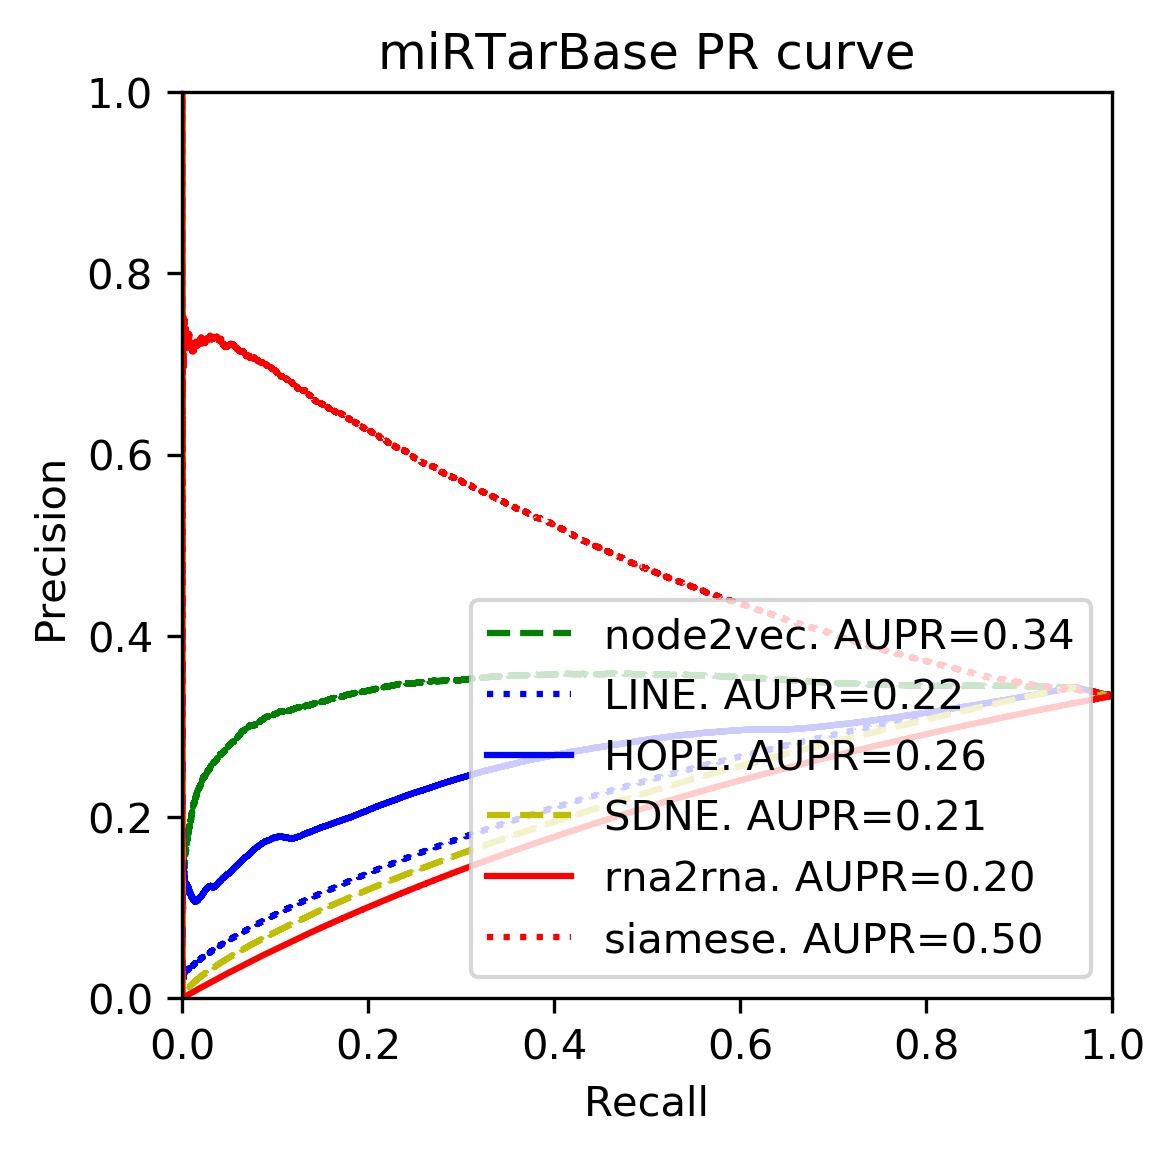

BioGRID
Ed_count: 31633 , Eu_count: 0 , En_count: 0


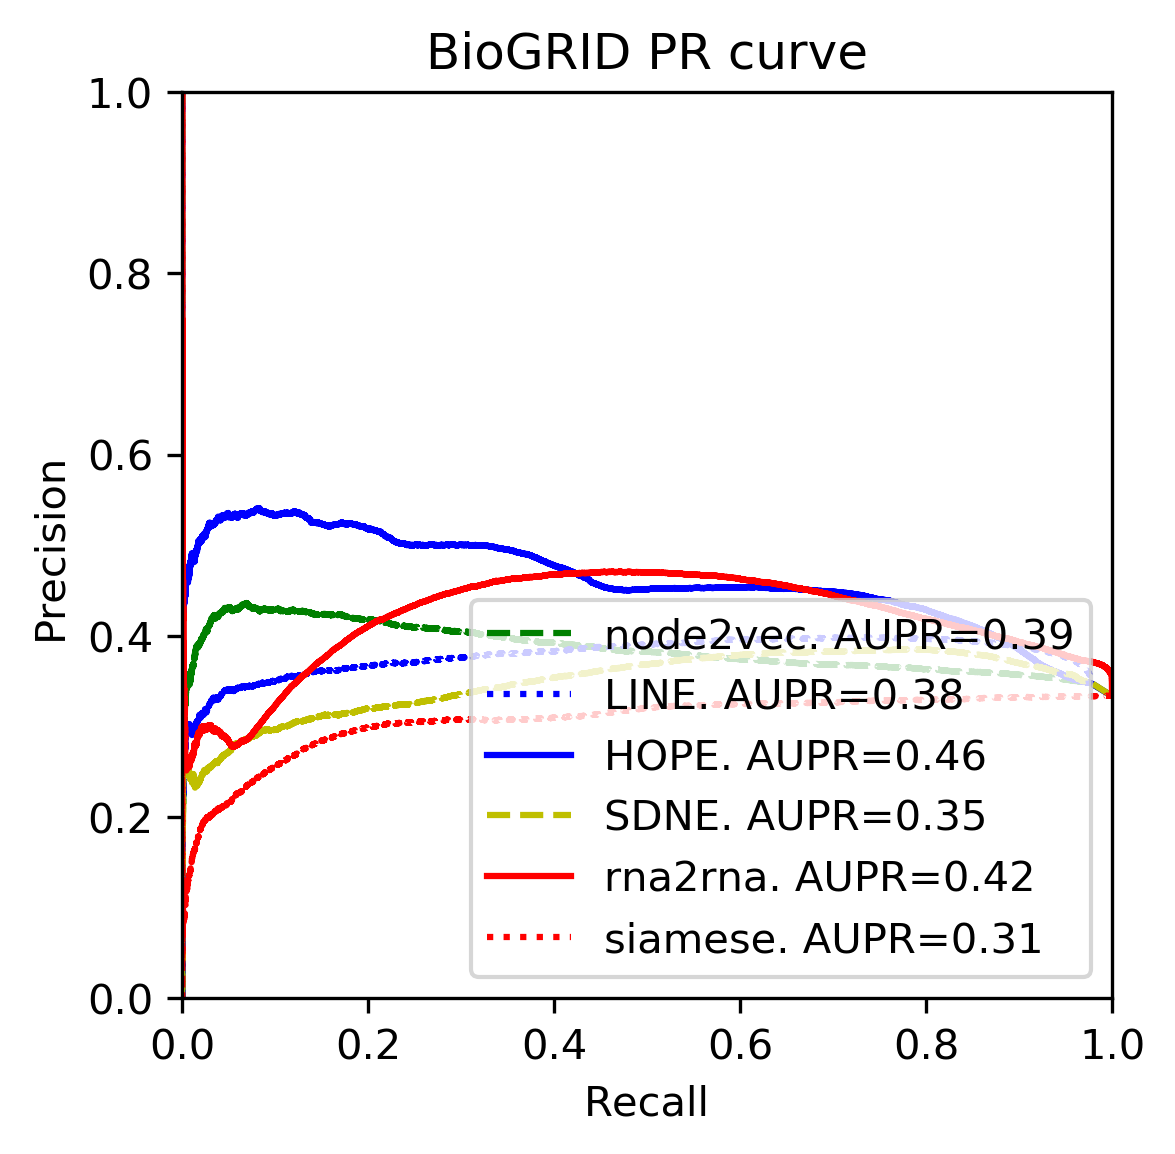

lncRInter
Ed_count: 191 , Eu_count: 0 , En_count: 0


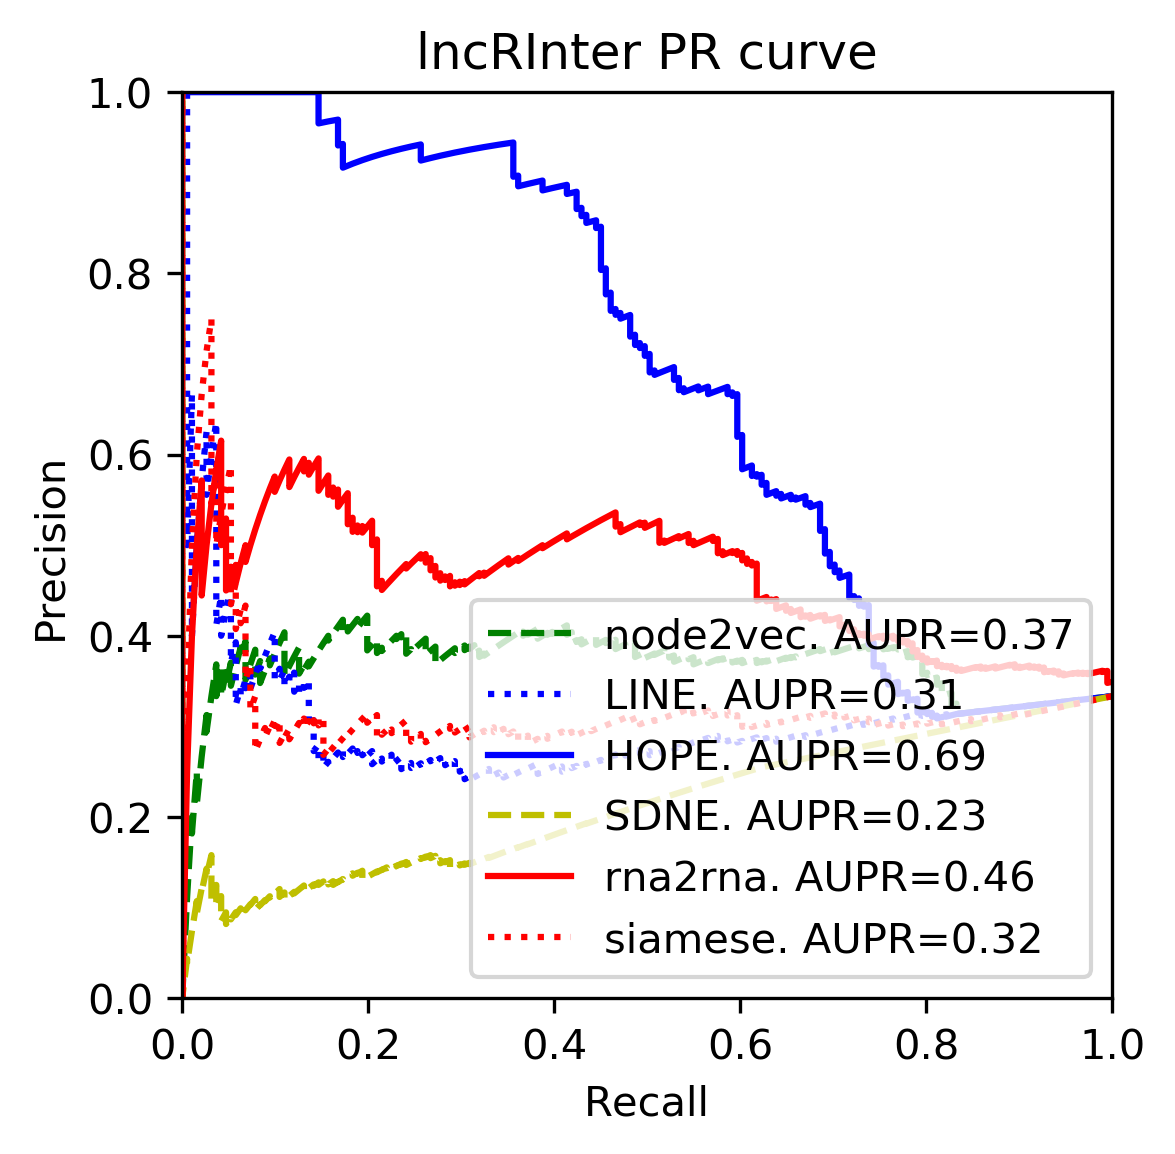

In [29]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_Ed, 
                                        databases=["lncrna2target", "miRTarBase", "BioGRID", "lncRInter"])

# Top-K Link Prediction

In [30]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                         node_list=methods[method].node_list, edge_type="d", top_k=500))

node2vec
{'precision': 0.0, 'recall': 0.0}
LINE
{'precision': 0.0, 'recall': 0.0}
HOPE
{'precision': 0.0, 'recall': 0.0}
SDNE
{'precision': 0.0, 'recall': 0.0}
rna2rna
{'precision': 0.004, 'recall': 2.2553762531434306e-05}
siamese
{'precision': 0.0, 'recall': 0.0}


In [31]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.48498263667906605, 'completeness': 0.531774824665435, 'nmi': 0.507302019194935}
LINE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.49575321653929855, 'completeness': 0.5358625720043556, 'nmi': 0.5150281658042678}
HOPE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3921747704833031, 'completeness': 0.49652090830914425, 'nmi': 0.4382219423433855}
SDNE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3849890580270227, 'completeness': 0.4934218881583918, 'nmi': 0.43251288877248834}
rna2rna
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.48093398072092064, 'completeness': 0.5373728085116525, 'nmi': 0.5075893564913947}
siamese
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.4803286707701826, 'completeness': 0.5098952453832185, 'nmi': 0.4946705516836173}


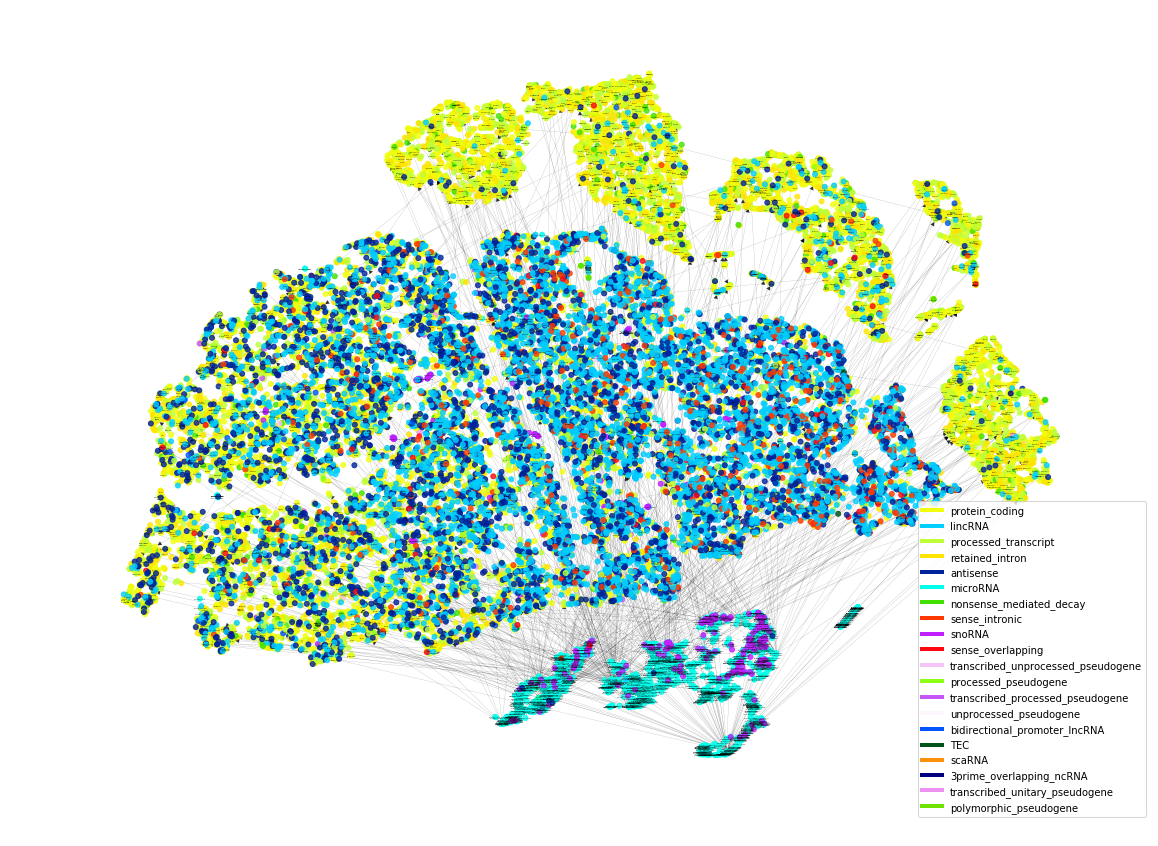

In [10]:
from moge.visualization.visualize_embedding import visualize_embedding
# siamese.process_embeddings(variable_length=False)
# delattr(siamese, "node_pos")
nodes_to_visualize = list(set(siamese.generator_train.get_nonzero_nodelist()) | set(siamese.generator_val.get_nonzero_nodelist()))
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=nodes_to_visualize, 
                                                      edge_types=["d"])[:500],
                    test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="gist_ncar",)

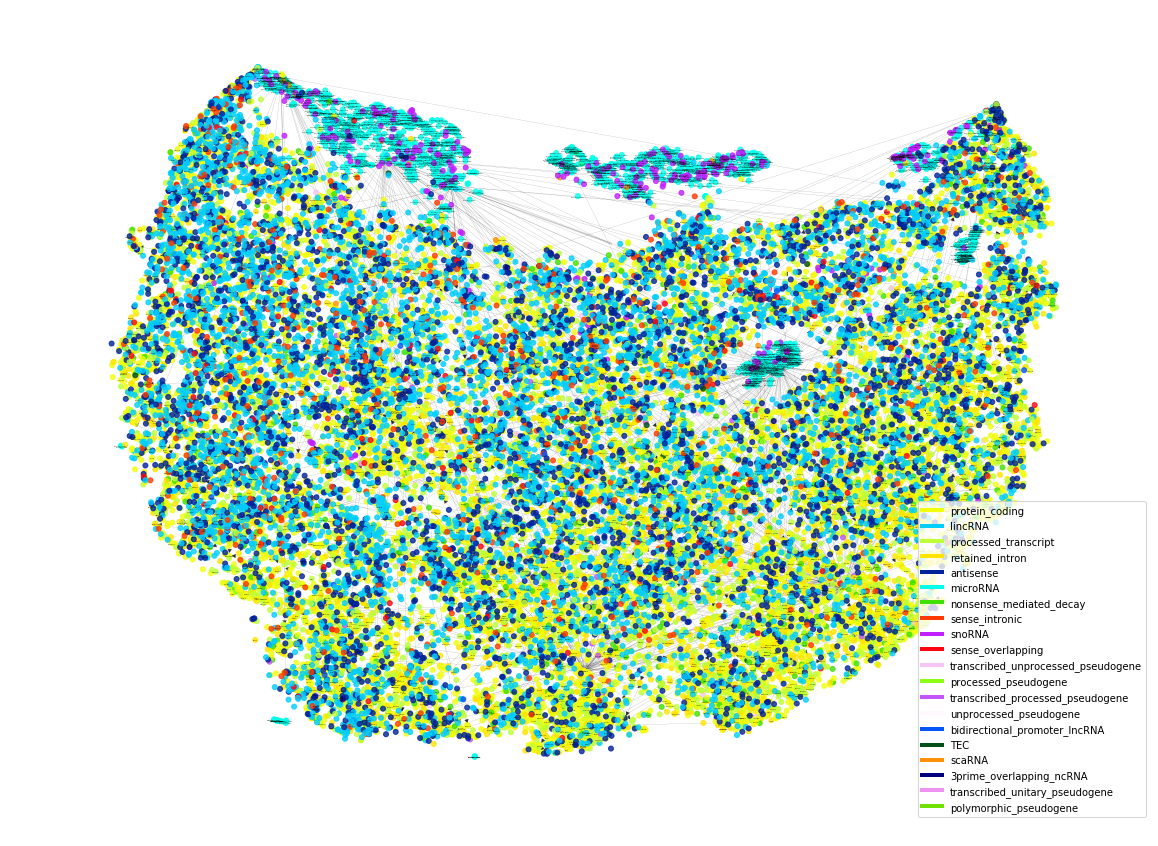

In [32]:
siamese.process_embeddings(variable_length=True, minlen=200)
delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=nodes_to_visualize, 
                                                      edge_types=["d"])[:500],
                    test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="gist_ncar",)

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Disease association", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])

In [ ]:
for method in methods.keys():
    print("\n", method)
    print(methods[method].get_scalefree_fit_score(methods[method].node_list))
    # for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
    #    print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))

/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(degrees, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


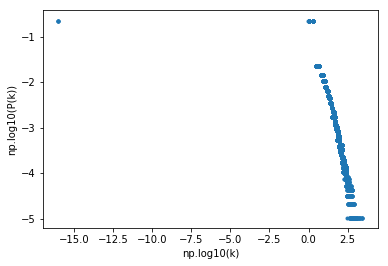

0.8423381196737936

In [25]:
from moge.evaluation.utils import get_scalefree_fit_score
adj = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)
network_degrees = np.sum(adj, axis=1)
get_scalefree_fit_score(network_degrees, plot=True)

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>